In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Choose Dataset

In [2]:
DATASET = 'mnist'
if DATASET     == 'mnist':
    epochs     = 500
    #lr         = 0.00004
    lr         = 0.01
    momentum   = 0.0    
    mean_imgs  = 0.1307
    std_imgs   = 0.3081
    imgs_shape = (1,28,28)

In [3]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
RES = os.path.join(ROOT,'results')

In [4]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm

from mnist_archs import LeNet
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [5]:
bs = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print(kwargs)

{'num_workers': 2, 'pin_memory': True}


In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(ROOT +  '/data/' + DATASET, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                                           
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    
    datasets.MNIST(ROOT + '/data/' + DATASET, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                       
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

In [7]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])


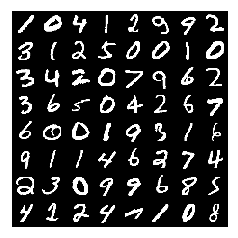

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

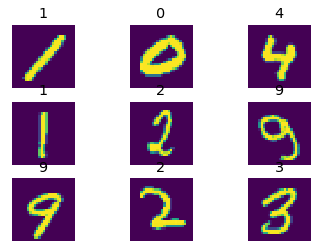

In [9]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i].item())

# Initialize network, optimizer and loss

In [10]:
model = LeNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = F.nll_loss

In [11]:
print(model)
print( summary(model, imgs_shape) )

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]            5020
            Linear-3                   [-1, 50]           16050
            Linear-4                   [-1, 10]             510
Total params: tensor(21840)
Trainable params: tensor(21840)
Non-trainable params: tensor(0)
----------------------------------------------------------------
None


In [12]:
train_loss   = []
train_acc    = []
valid_loss   = []
valid_acc    = []

In [13]:
F = []
for epoch in tqdm(range(epochs)):
    
    # init auxiliary grad and grad2
    auxgrad  = init_grad(model)
    auxgrad2 = init_grad(model)
    
        
    num_mb = 0
    for i, data in enumerate(train_loader, 0):
        
        num_mb += 1
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # compute the grad
        loss.backward()
                
        # accumulate grad and grad2
        auxgrad  = acc_grad(auxgrad,model)
        auxgrad2 = acc_grad2(auxgrad2,model)
        
    
    # compute the snr 
    snr = compute_snr(auxgrad, auxgrad2, num_mb)
    
    # temper the grad with the information on grad2
    f = []
    with torch.no_grad():
        for param, s in zip(model.parameters(), snr): 
            
            #param.grad = torch.where(s > 1, param.grad, 
            #                          torch.zeros(param.grad.size()).to(device) )
            
            param.grad = torch.where(s > 1, param.grad, 
                                      s*param.grad)
            f.append(  ( s < 1).sum().item() / 
                     torch.prod(torch.tensor( s.size() ) ).item()  )       
    F.append(f)
    
    # this is now outside (modify learning rate accordingly ???)
    optimizer.step()
        
        
    # save model
    torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # print statistics
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        valid_loss.append(l)
    
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        train_loss.append(l)        
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        valid_acc.append(acc)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        train_acc.append(acc)
        
    # print statistics
    print('Test loss : %g --- Test acc : %g %%' % ( valid_loss[-1], valid_acc[-1] )) 
   

  0%|          | 1/500 [00:07<1:01:48,  7.43s/it]

Test loss : 0.0361539 --- Test acc : 13.65 %


  0%|          | 2/500 [00:15<1:02:44,  7.56s/it]

Test loss : 0.0361371 --- Test acc : 13.72 %


  1%|          | 3/500 [00:22<1:02:13,  7.51s/it]

Test loss : 0.0361261 --- Test acc : 14.13 %


  1%|          | 4/500 [00:30<1:02:44,  7.59s/it]

Test loss : 0.0360969 --- Test acc : 14.26 %


  1%|          | 5/500 [00:38<1:03:49,  7.74s/it]

Test loss : 0.0360856 --- Test acc : 14.65 %


  1%|          | 6/500 [00:46<1:04:28,  7.83s/it]

Test loss : 0.0360583 --- Test acc : 15.02 %


  1%|▏         | 7/500 [00:54<1:04:33,  7.86s/it]

Test loss : 0.0360404 --- Test acc : 15.26 %


  2%|▏         | 8/500 [01:02<1:04:23,  7.85s/it]

Test loss : 0.0360354 --- Test acc : 15.53 %


  2%|▏         | 9/500 [01:10<1:04:22,  7.87s/it]

Test loss : 0.03603 --- Test acc : 15.33 %


  2%|▏         | 10/500 [01:18<1:04:22,  7.88s/it]

Test loss : 0.0360178 --- Test acc : 15.65 %


  2%|▏         | 11/500 [01:26<1:04:22,  7.90s/it]

Test loss : 0.035999 --- Test acc : 15.95 %


  2%|▏         | 12/500 [01:34<1:04:11,  7.89s/it]

Test loss : 0.0359837 --- Test acc : 16.05 %


  3%|▎         | 13/500 [01:42<1:04:04,  7.89s/it]

Test loss : 0.0359641 --- Test acc : 16.29 %


  3%|▎         | 14/500 [01:50<1:03:53,  7.89s/it]

Test loss : 0.0359447 --- Test acc : 16.77 %


  3%|▎         | 15/500 [01:58<1:03:49,  7.90s/it]

Test loss : 0.0359244 --- Test acc : 16.95 %


  3%|▎         | 16/500 [02:06<1:03:40,  7.89s/it]

Test loss : 0.0359114 --- Test acc : 17.29 %


  3%|▎         | 17/500 [02:14<1:03:32,  7.89s/it]

Test loss : 0.0358971 --- Test acc : 17.46 %


  4%|▎         | 18/500 [02:22<1:03:46,  7.94s/it]

Test loss : 0.0358739 --- Test acc : 18.06 %


  4%|▍         | 19/500 [02:30<1:03:38,  7.94s/it]

Test loss : 0.0358576 --- Test acc : 18.82 %


  4%|▍         | 20/500 [02:39<1:03:46,  7.97s/it]

Test loss : 0.035849 --- Test acc : 19.26 %


  4%|▍         | 21/500 [02:47<1:03:46,  7.99s/it]

Test loss : 0.0358354 --- Test acc : 19.65 %


  4%|▍         | 22/500 [02:55<1:03:37,  7.99s/it]

Test loss : 0.035814 --- Test acc : 20.11 %


  5%|▍         | 23/500 [03:03<1:03:31,  7.99s/it]

Test loss : 0.0357983 --- Test acc : 20.12 %


  5%|▍         | 24/500 [03:11<1:03:21,  7.99s/it]

Test loss : 0.0357831 --- Test acc : 21.06 %


  5%|▌         | 25/500 [03:19<1:03:10,  7.98s/it]

Test loss : 0.0357639 --- Test acc : 20.65 %


  5%|▌         | 26/500 [03:27<1:03:02,  7.98s/it]

Test loss : 0.0357527 --- Test acc : 21.05 %


  5%|▌         | 27/500 [03:35<1:02:52,  7.98s/it]

Test loss : 0.0357393 --- Test acc : 20.46 %


  6%|▌         | 28/500 [03:44<1:02:56,  8.00s/it]

Test loss : 0.0357274 --- Test acc : 20.96 %


  6%|▌         | 29/500 [03:51<1:02:46,  8.00s/it]

Test loss : 0.0357175 --- Test acc : 21.19 %


  6%|▌         | 30/500 [04:00<1:02:49,  8.02s/it]

Test loss : 0.0357131 --- Test acc : 20.97 %


  6%|▌         | 31/500 [04:09<1:02:52,  8.04s/it]

Test loss : 0.0356922 --- Test acc : 22.5 %


  6%|▋         | 32/500 [04:17<1:02:46,  8.05s/it]

Test loss : 0.0356786 --- Test acc : 22.99 %


  7%|▋         | 33/500 [04:25<1:02:41,  8.05s/it]

Test loss : 0.0356626 --- Test acc : 23 %


  7%|▋         | 34/500 [04:34<1:02:39,  8.07s/it]

Test loss : 0.0356512 --- Test acc : 22.61 %


  7%|▋         | 35/500 [04:42<1:02:29,  8.06s/it]

Test loss : 0.0356345 --- Test acc : 22.8 %


  7%|▋         | 36/500 [04:50<1:02:20,  8.06s/it]

Test loss : 0.0356178 --- Test acc : 22.3 %


  7%|▋         | 37/500 [04:58<1:02:11,  8.06s/it]

Test loss : 0.0355938 --- Test acc : 23.14 %


  8%|▊         | 38/500 [05:06<1:02:02,  8.06s/it]

Test loss : 0.0355766 --- Test acc : 23.31 %


  8%|▊         | 39/500 [05:14<1:01:53,  8.05s/it]

Test loss : 0.0355582 --- Test acc : 23.05 %


  8%|▊         | 40/500 [05:22<1:01:45,  8.06s/it]

Test loss : 0.0355386 --- Test acc : 22.93 %


  8%|▊         | 41/500 [05:30<1:01:37,  8.06s/it]

Test loss : 0.0355244 --- Test acc : 22.99 %


  8%|▊         | 42/500 [05:38<1:01:29,  8.06s/it]

Test loss : 0.0355101 --- Test acc : 23.09 %


  9%|▊         | 43/500 [05:46<1:01:20,  8.05s/it]

Test loss : 0.0354956 --- Test acc : 24.69 %


  9%|▉         | 44/500 [05:54<1:01:12,  8.05s/it]

Test loss : 0.035476 --- Test acc : 25.38 %


  9%|▉         | 45/500 [06:02<1:01:04,  8.05s/it]

Test loss : 0.0354593 --- Test acc : 25.09 %


  9%|▉         | 46/500 [06:10<1:00:55,  8.05s/it]

Test loss : 0.0354389 --- Test acc : 23.94 %


  9%|▉         | 47/500 [06:18<1:00:46,  8.05s/it]

Test loss : 0.035424 --- Test acc : 24.73 %


 10%|▉         | 48/500 [06:26<1:00:37,  8.05s/it]

Test loss : 0.0354042 --- Test acc : 25.61 %


 10%|▉         | 49/500 [06:34<1:00:28,  8.04s/it]

Test loss : 0.0353857 --- Test acc : 26.62 %


 10%|█         | 50/500 [06:42<1:00:19,  8.04s/it]

Test loss : 0.0353665 --- Test acc : 27.92 %


 10%|█         | 51/500 [06:50<1:00:10,  8.04s/it]

Test loss : 0.035345 --- Test acc : 28.35 %


 10%|█         | 52/500 [06:59<1:00:09,  8.06s/it]

Test loss : 0.0353206 --- Test acc : 29.1 %


 11%|█         | 53/500 [07:07<1:00:01,  8.06s/it]

Test loss : 0.0353084 --- Test acc : 30.65 %


 11%|█         | 54/500 [07:15<59:58,  8.07s/it]  

Test loss : 0.0352918 --- Test acc : 30.48 %


 11%|█         | 55/500 [07:24<59:53,  8.07s/it]

Test loss : 0.0352691 --- Test acc : 30.27 %


 11%|█         | 56/500 [07:32<59:44,  8.07s/it]

Test loss : 0.0352445 --- Test acc : 30.9 %


 11%|█▏        | 57/500 [07:40<59:37,  8.08s/it]

Test loss : 0.0352179 --- Test acc : 30.81 %


 12%|█▏        | 58/500 [07:49<59:34,  8.09s/it]

Test loss : 0.0352012 --- Test acc : 31.54 %


 12%|█▏        | 59/500 [07:57<59:27,  8.09s/it]

Test loss : 0.0351783 --- Test acc : 32.1 %


 12%|█▏        | 60/500 [08:06<59:24,  8.10s/it]

Test loss : 0.0351557 --- Test acc : 31.49 %


 12%|█▏        | 61/500 [08:14<59:17,  8.10s/it]

Test loss : 0.0351394 --- Test acc : 31.77 %


 12%|█▏        | 62/500 [08:22<59:11,  8.11s/it]

Test loss : 0.0351216 --- Test acc : 32.13 %


 13%|█▎        | 63/500 [08:31<59:04,  8.11s/it]

Test loss : 0.035098 --- Test acc : 31.98 %


 13%|█▎        | 64/500 [08:39<58:56,  8.11s/it]

Test loss : 0.035075 --- Test acc : 32.5 %


 13%|█▎        | 65/500 [08:46<58:46,  8.11s/it]

Test loss : 0.035042 --- Test acc : 32.48 %


 13%|█▎        | 66/500 [08:55<58:41,  8.12s/it]

Test loss : 0.0350232 --- Test acc : 32.61 %


 13%|█▎        | 67/500 [09:03<58:35,  8.12s/it]

Test loss : 0.0349967 --- Test acc : 31.43 %


 14%|█▎        | 68/500 [09:12<58:28,  8.12s/it]

Test loss : 0.0349679 --- Test acc : 32.47 %


 14%|█▍        | 69/500 [09:20<58:21,  8.13s/it]

Test loss : 0.0349475 --- Test acc : 34.17 %


 14%|█▍        | 70/500 [09:29<58:15,  8.13s/it]

Test loss : 0.0349119 --- Test acc : 34.38 %


 14%|█▍        | 71/500 [09:37<58:07,  8.13s/it]

Test loss : 0.0348827 --- Test acc : 34.83 %


 14%|█▍        | 72/500 [09:45<58:02,  8.14s/it]

Test loss : 0.0348647 --- Test acc : 34.48 %


 15%|█▍        | 73/500 [09:54<57:55,  8.14s/it]

Test loss : 0.0348395 --- Test acc : 35.52 %


 15%|█▍        | 74/500 [10:02<57:46,  8.14s/it]

Test loss : 0.0348182 --- Test acc : 35.58 %


 15%|█▌        | 75/500 [10:09<57:36,  8.13s/it]

Test loss : 0.0347811 --- Test acc : 36.09 %


 15%|█▌        | 76/500 [10:18<57:28,  8.13s/it]

Test loss : 0.0347529 --- Test acc : 35.53 %


 15%|█▌        | 77/500 [10:26<57:23,  8.14s/it]

Test loss : 0.0347213 --- Test acc : 36.34 %


 16%|█▌        | 78/500 [10:35<57:16,  8.14s/it]

Test loss : 0.0346897 --- Test acc : 37.4 %


 16%|█▌        | 79/500 [10:43<57:09,  8.15s/it]

Test loss : 0.0346615 --- Test acc : 38.49 %


 16%|█▌        | 80/500 [10:52<57:03,  8.15s/it]

Test loss : 0.0346305 --- Test acc : 39.97 %


 16%|█▌        | 81/500 [10:59<56:53,  8.15s/it]

Test loss : 0.0345966 --- Test acc : 40.65 %


 16%|█▋        | 82/500 [11:08<56:46,  8.15s/it]

Test loss : 0.0345588 --- Test acc : 41.88 %


 17%|█▋        | 83/500 [11:16<56:39,  8.15s/it]

Test loss : 0.0345237 --- Test acc : 42.08 %


 17%|█▋        | 84/500 [11:24<56:30,  8.15s/it]

Test loss : 0.0344837 --- Test acc : 42.08 %


 17%|█▋        | 85/500 [11:33<56:25,  8.16s/it]

Test loss : 0.034451 --- Test acc : 42.26 %


 17%|█▋        | 86/500 [11:41<56:16,  8.15s/it]

Test loss : 0.0344075 --- Test acc : 43.47 %


 17%|█▋        | 87/500 [11:49<56:10,  8.16s/it]

Test loss : 0.0343695 --- Test acc : 42.94 %


 18%|█▊        | 88/500 [11:58<56:01,  8.16s/it]

Test loss : 0.0343359 --- Test acc : 42.28 %


 18%|█▊        | 89/500 [12:06<55:54,  8.16s/it]

Test loss : 0.034295 --- Test acc : 41.05 %


 18%|█▊        | 90/500 [12:14<55:48,  8.17s/it]

Test loss : 0.0342515 --- Test acc : 40.47 %


 18%|█▊        | 91/500 [12:23<55:39,  8.17s/it]

Test loss : 0.0342151 --- Test acc : 40.82 %


 18%|█▊        | 92/500 [12:31<55:30,  8.16s/it]

Test loss : 0.0341754 --- Test acc : 40.11 %


 19%|█▊        | 93/500 [12:39<55:25,  8.17s/it]

Test loss : 0.0341332 --- Test acc : 40.45 %


 19%|█▉        | 94/500 [12:47<55:16,  8.17s/it]

Test loss : 0.0340925 --- Test acc : 41.71 %


 19%|█▉        | 95/500 [12:56<55:10,  8.17s/it]

Test loss : 0.0340367 --- Test acc : 42.85 %


 19%|█▉        | 96/500 [13:04<55:03,  8.18s/it]

Test loss : 0.0339903 --- Test acc : 44 %


 19%|█▉        | 97/500 [13:12<54:54,  8.18s/it]

Test loss : 0.0339458 --- Test acc : 44.13 %


 20%|█▉        | 98/500 [13:21<54:46,  8.18s/it]

Test loss : 0.0338955 --- Test acc : 44.28 %


 20%|█▉        | 99/500 [13:29<54:40,  8.18s/it]

Test loss : 0.0338507 --- Test acc : 45.48 %


 20%|██        | 100/500 [13:37<54:31,  8.18s/it]

Test loss : 0.0337953 --- Test acc : 44.69 %


 20%|██        | 101/500 [13:45<54:22,  8.18s/it]

Test loss : 0.0337388 --- Test acc : 44.14 %


 20%|██        | 102/500 [13:54<54:17,  8.18s/it]

Test loss : 0.0336857 --- Test acc : 43.63 %


 21%|██        | 103/500 [14:02<54:08,  8.18s/it]

Test loss : 0.0336383 --- Test acc : 44.02 %


 21%|██        | 104/500 [14:11<54:01,  8.18s/it]

Test loss : 0.0335841 --- Test acc : 45.16 %


 21%|██        | 105/500 [14:19<53:53,  8.19s/it]

Test loss : 0.0335207 --- Test acc : 44.61 %


 21%|██        | 106/500 [14:27<53:44,  8.19s/it]

Test loss : 0.0334552 --- Test acc : 45.34 %


 21%|██▏       | 107/500 [14:35<53:35,  8.18s/it]

Test loss : 0.0333908 --- Test acc : 46.51 %


 22%|██▏       | 108/500 [14:44<53:29,  8.19s/it]

Test loss : 0.0333378 --- Test acc : 46.04 %


 22%|██▏       | 109/500 [14:52<53:21,  8.19s/it]

Test loss : 0.0332755 --- Test acc : 46.09 %


 22%|██▏       | 110/500 [15:00<53:12,  8.19s/it]

Test loss : 0.0332243 --- Test acc : 45.97 %


 22%|██▏       | 111/500 [15:08<53:05,  8.19s/it]

Test loss : 0.0331492 --- Test acc : 44.11 %


 22%|██▏       | 112/500 [15:17<52:57,  8.19s/it]

Test loss : 0.0330882 --- Test acc : 44.11 %


 23%|██▎       | 113/500 [15:26<52:53,  8.20s/it]

Test loss : 0.0330205 --- Test acc : 44.33 %


 23%|██▎       | 114/500 [15:35<52:46,  8.20s/it]

Test loss : 0.0329422 --- Test acc : 46.15 %


 23%|██▎       | 115/500 [15:43<52:37,  8.20s/it]

Test loss : 0.0328555 --- Test acc : 47.34 %


 23%|██▎       | 116/500 [15:51<52:30,  8.21s/it]

Test loss : 0.032802 --- Test acc : 47.87 %


 23%|██▎       | 117/500 [16:00<52:24,  8.21s/it]

Test loss : 0.0327501 --- Test acc : 49.37 %


 24%|██▎       | 118/500 [16:08<52:16,  8.21s/it]

Test loss : 0.0326848 --- Test acc : 50.69 %


 24%|██▍       | 119/500 [16:17<52:08,  8.21s/it]

Test loss : 0.0326046 --- Test acc : 51.14 %


 24%|██▍       | 120/500 [16:25<52:01,  8.21s/it]

Test loss : 0.0325183 --- Test acc : 52.45 %


 24%|██▍       | 121/500 [16:34<51:53,  8.22s/it]

Test loss : 0.0324462 --- Test acc : 51.84 %


 24%|██▍       | 122/500 [16:42<51:44,  8.21s/it]

Test loss : 0.0323774 --- Test acc : 51.23 %


 25%|██▍       | 123/500 [16:50<51:35,  8.21s/it]

Test loss : 0.0322645 --- Test acc : 52.57 %


 25%|██▍       | 124/500 [16:58<51:28,  8.22s/it]

Test loss : 0.0321755 --- Test acc : 52.76 %


 25%|██▌       | 125/500 [17:07<51:21,  8.22s/it]

Test loss : 0.0320661 --- Test acc : 52.89 %


 25%|██▌       | 126/500 [17:15<51:13,  8.22s/it]

Test loss : 0.0319641 --- Test acc : 51.5 %


 25%|██▌       | 127/500 [17:23<51:05,  8.22s/it]

Test loss : 0.0318714 --- Test acc : 53.07 %


 26%|██▌       | 128/500 [17:32<50:58,  8.22s/it]

Test loss : 0.0317552 --- Test acc : 51.36 %


 26%|██▌       | 129/500 [17:40<50:50,  8.22s/it]

Test loss : 0.0316305 --- Test acc : 52.64 %


 26%|██▌       | 130/500 [17:49<50:43,  8.22s/it]

Test loss : 0.0315411 --- Test acc : 51.71 %


 26%|██▌       | 131/500 [17:57<50:35,  8.23s/it]

Test loss : 0.031397 --- Test acc : 52.27 %


 26%|██▋       | 132/500 [18:06<50:27,  8.23s/it]

Test loss : 0.0312869 --- Test acc : 53.4 %


 27%|██▋       | 133/500 [18:14<50:20,  8.23s/it]

Test loss : 0.03116 --- Test acc : 55.54 %


 27%|██▋       | 134/500 [18:22<50:12,  8.23s/it]

Test loss : 0.0310337 --- Test acc : 54.16 %


 27%|██▋       | 135/500 [18:31<50:05,  8.23s/it]

Test loss : 0.0309098 --- Test acc : 51.03 %


 27%|██▋       | 136/500 [18:39<49:57,  8.23s/it]

Test loss : 0.030785 --- Test acc : 52.63 %


 27%|██▋       | 137/500 [18:48<49:49,  8.23s/it]

Test loss : 0.030639 --- Test acc : 53.37 %


 28%|██▊       | 138/500 [18:56<49:41,  8.24s/it]

Test loss : 0.0305239 --- Test acc : 53.22 %


 28%|██▊       | 139/500 [19:05<49:33,  8.24s/it]

Test loss : 0.0303116 --- Test acc : 58.16 %


 28%|██▊       | 140/500 [19:13<49:24,  8.24s/it]

Test loss : 0.0301776 --- Test acc : 57.41 %


 28%|██▊       | 141/500 [19:21<49:17,  8.24s/it]

Test loss : 0.0300566 --- Test acc : 53.79 %


 28%|██▊       | 142/500 [19:30<49:10,  8.24s/it]

Test loss : 0.0299528 --- Test acc : 53.5 %


 29%|██▊       | 143/500 [19:38<49:02,  8.24s/it]

Test loss : 0.0297166 --- Test acc : 57.93 %


 29%|██▉       | 144/500 [19:46<48:53,  8.24s/it]

Test loss : 0.0295948 --- Test acc : 60.37 %


 29%|██▉       | 145/500 [19:55<48:46,  8.24s/it]

Test loss : 0.0294016 --- Test acc : 63.45 %


 29%|██▉       | 146/500 [20:03<48:37,  8.24s/it]

Test loss : 0.0292313 --- Test acc : 62.88 %


 29%|██▉       | 147/500 [20:11<48:29,  8.24s/it]

Test loss : 0.0291003 --- Test acc : 61.82 %


 30%|██▉       | 148/500 [20:19<48:21,  8.24s/it]

Test loss : 0.028965 --- Test acc : 61.59 %


 30%|██▉       | 149/500 [20:28<48:13,  8.24s/it]

Test loss : 0.0287688 --- Test acc : 62.31 %


 30%|███       | 150/500 [20:36<48:05,  8.25s/it]

Test loss : 0.0285619 --- Test acc : 63.35 %


 30%|███       | 151/500 [20:45<47:58,  8.25s/it]

Test loss : 0.0283093 --- Test acc : 64.19 %


 30%|███       | 152/500 [20:53<47:50,  8.25s/it]

Test loss : 0.0281098 --- Test acc : 63.95 %


 31%|███       | 153/500 [21:02<47:42,  8.25s/it]

Test loss : 0.0279998 --- Test acc : 62.36 %


 31%|███       | 154/500 [21:11<47:36,  8.26s/it]

Test loss : 0.0277523 --- Test acc : 62.41 %


 31%|███       | 155/500 [21:19<47:28,  8.26s/it]

Test loss : 0.0275252 --- Test acc : 62.41 %


 31%|███       | 156/500 [21:27<47:19,  8.25s/it]

Test loss : 0.02719 --- Test acc : 66.11 %


 31%|███▏      | 157/500 [21:35<47:10,  8.25s/it]

Test loss : 0.0269675 --- Test acc : 67.44 %


 32%|███▏      | 158/500 [21:44<47:03,  8.26s/it]

Test loss : 0.0268125 --- Test acc : 65.77 %


 32%|███▏      | 159/500 [21:53<46:56,  8.26s/it]

Test loss : 0.0265113 --- Test acc : 66.75 %


 32%|███▏      | 160/500 [22:01<46:47,  8.26s/it]

Test loss : 0.026372 --- Test acc : 64.96 %


 32%|███▏      | 161/500 [22:09<46:40,  8.26s/it]

Test loss : 0.0260845 --- Test acc : 65.41 %


 32%|███▏      | 162/500 [22:18<46:32,  8.26s/it]

Test loss : 0.0259213 --- Test acc : 62.89 %


 33%|███▎      | 163/500 [22:26<46:24,  8.26s/it]

Test loss : 0.0255112 --- Test acc : 67.37 %


 33%|███▎      | 164/500 [22:34<46:15,  8.26s/it]

Test loss : 0.0253061 --- Test acc : 66.76 %


 33%|███▎      | 165/500 [22:43<46:08,  8.26s/it]

Test loss : 0.0249799 --- Test acc : 66.94 %


 33%|███▎      | 166/500 [22:51<45:59,  8.26s/it]

Test loss : 0.0247126 --- Test acc : 63.83 %


 33%|███▎      | 167/500 [22:59<45:50,  8.26s/it]

Test loss : 0.0245324 --- Test acc : 61.16 %


 34%|███▎      | 168/500 [23:08<45:43,  8.26s/it]

Test loss : 0.0242129 --- Test acc : 61.69 %


 34%|███▍      | 169/500 [23:16<45:35,  8.26s/it]

Test loss : 0.0240086 --- Test acc : 63.9 %


 34%|███▍      | 170/500 [23:24<45:27,  8.26s/it]

Test loss : 0.0236279 --- Test acc : 67.77 %


 34%|███▍      | 171/500 [23:33<45:19,  8.27s/it]

Test loss : 0.0232467 --- Test acc : 70.2 %


 34%|███▍      | 172/500 [23:41<45:11,  8.27s/it]

Test loss : 0.0231553 --- Test acc : 66.72 %


 35%|███▍      | 173/500 [23:50<45:03,  8.27s/it]

Test loss : 0.0228772 --- Test acc : 66.2 %


 35%|███▍      | 174/500 [23:58<44:55,  8.27s/it]

Test loss : 0.0228151 --- Test acc : 69.11 %


 35%|███▌      | 175/500 [24:06<44:46,  8.27s/it]

Test loss : 0.0220362 --- Test acc : 70.11 %


 35%|███▌      | 176/500 [24:15<44:39,  8.27s/it]

Test loss : 0.0216576 --- Test acc : 70.53 %


 35%|███▌      | 177/500 [24:23<44:31,  8.27s/it]

Test loss : 0.0214483 --- Test acc : 66.27 %


 36%|███▌      | 178/500 [24:32<44:23,  8.27s/it]

Test loss : 0.0214068 --- Test acc : 67.24 %


 36%|███▌      | 179/500 [24:40<44:15,  8.27s/it]

Test loss : 0.0208265 --- Test acc : 68.7 %


 36%|███▌      | 180/500 [24:48<44:06,  8.27s/it]

Test loss : 0.0207994 --- Test acc : 70.82 %


 36%|███▌      | 181/500 [24:57<43:58,  8.27s/it]

Test loss : 0.0203307 --- Test acc : 71.02 %


 36%|███▋      | 182/500 [25:05<43:50,  8.27s/it]

Test loss : 0.0200553 --- Test acc : 72.15 %


 37%|███▋      | 183/500 [25:13<43:42,  8.27s/it]

Test loss : 0.0196829 --- Test acc : 70.45 %


 37%|███▋      | 184/500 [25:22<43:34,  8.27s/it]

Test loss : 0.0192138 --- Test acc : 73.22 %


 37%|███▋      | 185/500 [25:30<43:25,  8.27s/it]

Test loss : 0.0192958 --- Test acc : 67.61 %


 37%|███▋      | 186/500 [25:38<43:17,  8.27s/it]

Test loss : 0.0187486 --- Test acc : 73.63 %


 37%|███▋      | 187/500 [25:47<43:09,  8.27s/it]

Test loss : 0.0187124 --- Test acc : 75 %


 38%|███▊      | 188/500 [25:55<43:01,  8.27s/it]

Test loss : 0.0187766 --- Test acc : 69.73 %


 38%|███▊      | 189/500 [26:03<42:52,  8.27s/it]

Test loss : 0.0182029 --- Test acc : 74.86 %


 38%|███▊      | 190/500 [26:11<42:44,  8.27s/it]

Test loss : 0.0178143 --- Test acc : 75.44 %


 38%|███▊      | 191/500 [26:19<42:35,  8.27s/it]

Test loss : 0.017729 --- Test acc : 77.48 %


 38%|███▊      | 192/500 [26:28<42:28,  8.27s/it]

Test loss : 0.0171478 --- Test acc : 79.32 %


 39%|███▊      | 193/500 [26:36<42:20,  8.27s/it]

Test loss : 0.0172844 --- Test acc : 72.79 %


 39%|███▉      | 194/500 [26:44<42:11,  8.27s/it]

Test loss : 0.0167615 --- Test acc : 74.69 %


 39%|███▉      | 195/500 [26:53<42:03,  8.27s/it]

Test loss : 0.0167153 --- Test acc : 72.54 %


 39%|███▉      | 196/500 [27:01<41:55,  8.27s/it]

Test loss : 0.0168947 --- Test acc : 69.64 %


 39%|███▉      | 197/500 [27:10<41:47,  8.27s/it]

Test loss : 0.0167852 --- Test acc : 73.23 %


 40%|███▉      | 198/500 [27:18<41:39,  8.28s/it]

Test loss : 0.0163452 --- Test acc : 74.36 %


 40%|███▉      | 199/500 [27:27<41:31,  8.28s/it]

Test loss : 0.0156632 --- Test acc : 77.27 %


 40%|████      | 200/500 [27:35<41:23,  8.28s/it]

Test loss : 0.0152836 --- Test acc : 78.92 %


 40%|████      | 201/500 [27:44<41:15,  8.28s/it]

Test loss : 0.0159621 --- Test acc : 74.1 %


 40%|████      | 202/500 [27:52<41:07,  8.28s/it]

Test loss : 0.0153668 --- Test acc : 75.99 %


 41%|████      | 203/500 [28:01<40:59,  8.28s/it]

Test loss : 0.0148848 --- Test acc : 75.4 %


 41%|████      | 204/500 [28:09<40:51,  8.28s/it]

Test loss : 0.0143864 --- Test acc : 80.5 %


 41%|████      | 205/500 [28:17<40:42,  8.28s/it]

Test loss : 0.0151951 --- Test acc : 74.01 %


 41%|████      | 206/500 [28:25<40:34,  8.28s/it]

Test loss : 0.0140403 --- Test acc : 80.85 %


 41%|████▏     | 207/500 [28:34<40:26,  8.28s/it]

Test loss : 0.0145287 --- Test acc : 74.01 %


 42%|████▏     | 208/500 [28:42<40:18,  8.28s/it]

Test loss : 0.0141369 --- Test acc : 76.66 %


 42%|████▏     | 209/500 [28:51<40:10,  8.28s/it]

Test loss : 0.0135735 --- Test acc : 79.42 %


 42%|████▏     | 210/500 [28:59<40:01,  8.28s/it]

Test loss : 0.014287 --- Test acc : 72.71 %


 42%|████▏     | 211/500 [29:07<39:53,  8.28s/it]

Test loss : 0.0132678 --- Test acc : 78.85 %


 42%|████▏     | 212/500 [29:16<39:45,  8.28s/it]

Test loss : 0.0143593 --- Test acc : 70.41 %


 43%|████▎     | 213/500 [29:24<39:37,  8.28s/it]

Test loss : 0.0146234 --- Test acc : 74.01 %


 43%|████▎     | 214/500 [29:32<39:28,  8.28s/it]

Test loss : 0.0128143 --- Test acc : 82.47 %


 43%|████▎     | 215/500 [29:40<39:20,  8.28s/it]

Test loss : 0.0135066 --- Test acc : 75.49 %


 43%|████▎     | 216/500 [29:48<39:11,  8.28s/it]

Test loss : 0.0126613 --- Test acc : 82.13 %


 43%|████▎     | 217/500 [29:56<39:02,  8.28s/it]

Test loss : 0.0128801 --- Test acc : 79.63 %


 44%|████▎     | 218/500 [30:05<38:55,  8.28s/it]

Test loss : 0.012839 --- Test acc : 79.36 %


 44%|████▍     | 219/500 [30:13<38:46,  8.28s/it]

Test loss : 0.0125712 --- Test acc : 78.65 %


 44%|████▍     | 220/500 [30:21<38:37,  8.28s/it]

Test loss : 0.0127386 --- Test acc : 79.91 %


 44%|████▍     | 221/500 [30:29<38:29,  8.28s/it]

Test loss : 0.0122157 --- Test acc : 80.45 %


 44%|████▍     | 222/500 [30:37<38:21,  8.28s/it]

Test loss : 0.0117997 --- Test acc : 81.75 %


 45%|████▍     | 223/500 [30:46<38:13,  8.28s/it]

Test loss : 0.0122259 --- Test acc : 80.11 %


 45%|████▍     | 224/500 [30:54<38:05,  8.28s/it]

Test loss : 0.0119689 --- Test acc : 80.64 %


 45%|████▌     | 225/500 [31:02<37:56,  8.28s/it]

Test loss : 0.0113825 --- Test acc : 81.73 %


 45%|████▌     | 226/500 [31:10<37:47,  8.28s/it]

Test loss : 0.0113793 --- Test acc : 81.3 %


 45%|████▌     | 227/500 [31:19<37:40,  8.28s/it]

Test loss : 0.0112954 --- Test acc : 81.04 %


 46%|████▌     | 228/500 [31:27<37:31,  8.28s/it]

Test loss : 0.0115703 --- Test acc : 79.28 %


 46%|████▌     | 229/500 [31:35<37:23,  8.28s/it]

Test loss : 0.0116013 --- Test acc : 80.12 %


 46%|████▌     | 230/500 [31:44<37:15,  8.28s/it]

Test loss : 0.0110084 --- Test acc : 81.74 %


 46%|████▌     | 231/500 [31:52<37:07,  8.28s/it]

Test loss : 0.0110476 --- Test acc : 82.71 %


 46%|████▋     | 232/500 [32:00<36:59,  8.28s/it]

Test loss : 0.0110205 --- Test acc : 81.91 %


 47%|████▋     | 233/500 [32:09<36:50,  8.28s/it]

Test loss : 0.0105948 --- Test acc : 83.11 %


 47%|████▋     | 234/500 [32:17<36:42,  8.28s/it]

Test loss : 0.0105321 --- Test acc : 83.38 %


 47%|████▋     | 235/500 [32:25<36:33,  8.28s/it]

Test loss : 0.010655 --- Test acc : 81.79 %


 47%|████▋     | 236/500 [32:33<36:24,  8.28s/it]

Test loss : 0.0104296 --- Test acc : 82.98 %


 47%|████▋     | 237/500 [32:41<36:16,  8.28s/it]

Test loss : 0.010418 --- Test acc : 81.91 %


 48%|████▊     | 238/500 [32:49<36:08,  8.28s/it]

Test loss : 0.0101521 --- Test acc : 83.67 %


 48%|████▊     | 239/500 [32:57<36:00,  8.28s/it]

Test loss : 0.0100495 --- Test acc : 84.32 %


 48%|████▊     | 240/500 [33:06<35:51,  8.28s/it]

Test loss : 0.0100595 --- Test acc : 83.15 %


 48%|████▊     | 241/500 [33:14<35:43,  8.28s/it]

Test loss : 0.0103022 --- Test acc : 81.2 %


 48%|████▊     | 242/500 [33:22<35:35,  8.28s/it]

Test loss : 0.0122532 --- Test acc : 74.61 %


 49%|████▊     | 243/500 [33:30<35:26,  8.28s/it]

Test loss : 0.0124189 --- Test acc : 72.87 %


 49%|████▉     | 244/500 [33:39<35:18,  8.28s/it]

Test loss : 0.0110258 --- Test acc : 77.08 %


 49%|████▉     | 245/500 [33:47<35:10,  8.28s/it]

Test loss : 0.0129673 --- Test acc : 71.89 %


 49%|████▉     | 246/500 [33:56<35:02,  8.28s/it]

Test loss : 0.0107831 --- Test acc : 78.8 %


 49%|████▉     | 247/500 [34:04<34:54,  8.28s/it]

Test loss : 0.0113524 --- Test acc : 77.15 %


 50%|████▉     | 248/500 [34:13<34:46,  8.28s/it]

Test loss : 0.00956966 --- Test acc : 84.12 %


 50%|████▉     | 249/500 [34:21<34:38,  8.28s/it]

Test loss : 0.0103134 --- Test acc : 80.17 %


 50%|█████     | 250/500 [34:30<34:30,  8.28s/it]

Test loss : 0.0106325 --- Test acc : 79.5 %


 50%|█████     | 251/500 [34:38<34:21,  8.28s/it]

Test loss : 0.0110198 --- Test acc : 79.27 %


 50%|█████     | 252/500 [34:46<34:13,  8.28s/it]

Test loss : 0.00984714 --- Test acc : 82.99 %


 51%|█████     | 253/500 [34:55<34:05,  8.28s/it]

Test loss : 0.00963936 --- Test acc : 83.47 %


 51%|█████     | 254/500 [35:03<33:57,  8.28s/it]

Test loss : 0.0094739 --- Test acc : 84.18 %


 51%|█████     | 255/500 [35:11<33:48,  8.28s/it]

Test loss : 0.0093644 --- Test acc : 84.26 %


 51%|█████     | 256/500 [35:20<33:40,  8.28s/it]

Test loss : 0.00963669 --- Test acc : 82.47 %


 51%|█████▏    | 257/500 [35:28<33:32,  8.28s/it]

Test loss : 0.0117021 --- Test acc : 74.56 %


 52%|█████▏    | 258/500 [35:36<33:24,  8.28s/it]

Test loss : 0.013803 --- Test acc : 69.72 %


 52%|█████▏    | 259/500 [35:45<33:16,  8.28s/it]

Test loss : 0.010129 --- Test acc : 81.06 %


 52%|█████▏    | 260/500 [35:53<33:07,  8.28s/it]

Test loss : 0.00945893 --- Test acc : 83.82 %


 52%|█████▏    | 261/500 [36:02<32:59,  8.28s/it]

Test loss : 0.00935174 --- Test acc : 84.04 %


 52%|█████▏    | 262/500 [36:10<32:51,  8.28s/it]

Test loss : 0.00890107 --- Test acc : 84.97 %


 53%|█████▎    | 263/500 [36:19<32:43,  8.29s/it]

Test loss : 0.00914558 --- Test acc : 83.62 %


 53%|█████▎    | 264/500 [36:27<32:35,  8.29s/it]

Test loss : 0.00969223 --- Test acc : 80.54 %


 53%|█████▎    | 265/500 [36:35<32:26,  8.28s/it]

Test loss : 0.0103405 --- Test acc : 78.6 %


 53%|█████▎    | 266/500 [36:43<32:18,  8.28s/it]

Test loss : 0.00890214 --- Test acc : 83.42 %


 53%|█████▎    | 267/500 [36:51<32:09,  8.28s/it]

Test loss : 0.0093076 --- Test acc : 82.42 %


 54%|█████▎    | 268/500 [36:59<32:01,  8.28s/it]

Test loss : 0.00864057 --- Test acc : 84.07 %


 54%|█████▍    | 269/500 [37:08<31:53,  8.28s/it]

Test loss : 0.00852419 --- Test acc : 84.85 %


 54%|█████▍    | 270/500 [37:16<31:45,  8.28s/it]

Test loss : 0.00928348 --- Test acc : 81.14 %


 54%|█████▍    | 271/500 [37:24<31:36,  8.28s/it]

Test loss : 0.0086803 --- Test acc : 84.19 %


 54%|█████▍    | 272/500 [37:32<31:28,  8.28s/it]

Test loss : 0.00828668 --- Test acc : 86.21 %


 55%|█████▍    | 273/500 [37:41<31:20,  8.28s/it]

Test loss : 0.0085979 --- Test acc : 84.53 %


 55%|█████▍    | 274/500 [37:49<31:11,  8.28s/it]

Test loss : 0.0083784 --- Test acc : 85.2 %


 55%|█████▌    | 275/500 [37:58<31:03,  8.28s/it]

Test loss : 0.00873079 --- Test acc : 83.89 %


 55%|█████▌    | 276/500 [38:06<30:55,  8.28s/it]

Test loss : 0.00883131 --- Test acc : 83.18 %


 55%|█████▌    | 277/500 [38:14<30:47,  8.28s/it]

Test loss : 0.00858964 --- Test acc : 85.02 %


 56%|█████▌    | 278/500 [38:23<30:39,  8.29s/it]

Test loss : 0.00806513 --- Test acc : 85.99 %


 56%|█████▌    | 279/500 [38:31<30:31,  8.29s/it]

Test loss : 0.00856567 --- Test acc : 84.76 %


 56%|█████▌    | 280/500 [38:40<30:22,  8.29s/it]

Test loss : 0.00959425 --- Test acc : 80.48 %


 56%|█████▌    | 281/500 [38:48<30:14,  8.29s/it]

Test loss : 0.00798558 --- Test acc : 85.91 %


 56%|█████▋    | 282/500 [38:56<30:06,  8.29s/it]

Test loss : 0.00865772 --- Test acc : 82.14 %


 57%|█████▋    | 283/500 [39:05<29:58,  8.29s/it]

Test loss : 0.00785125 --- Test acc : 86.09 %


 57%|█████▋    | 284/500 [39:13<29:50,  8.29s/it]

Test loss : 0.00783568 --- Test acc : 86.94 %


 57%|█████▋    | 285/500 [39:21<29:41,  8.29s/it]

Test loss : 0.00856674 --- Test acc : 83.44 %


 57%|█████▋    | 286/500 [39:29<29:33,  8.29s/it]

Test loss : 0.00818777 --- Test acc : 85.76 %


 57%|█████▋    | 287/500 [39:38<29:25,  8.29s/it]

Test loss : 0.00866083 --- Test acc : 82.21 %


 58%|█████▊    | 288/500 [39:47<29:17,  8.29s/it]

Test loss : 0.00842827 --- Test acc : 84.71 %


 58%|█████▊    | 289/500 [39:55<29:08,  8.29s/it]

Test loss : 0.00834922 --- Test acc : 84.12 %


 58%|█████▊    | 290/500 [40:03<29:00,  8.29s/it]

Test loss : 0.00860751 --- Test acc : 84.36 %


 58%|█████▊    | 291/500 [40:11<28:52,  8.29s/it]

Test loss : 0.00962882 --- Test acc : 77.93 %


 58%|█████▊    | 292/500 [40:20<28:44,  8.29s/it]

Test loss : 0.00936632 --- Test acc : 81.97 %


 59%|█████▊    | 293/500 [40:28<28:35,  8.29s/it]

Test loss : 0.00776172 --- Test acc : 86.5 %


 59%|█████▉    | 294/500 [40:37<28:27,  8.29s/it]

Test loss : 0.0081677 --- Test acc : 85.21 %


 59%|█████▉    | 295/500 [40:45<28:19,  8.29s/it]

Test loss : 0.0077383 --- Test acc : 85.83 %


 59%|█████▉    | 296/500 [40:53<28:11,  8.29s/it]

Test loss : 0.00767264 --- Test acc : 85.81 %


 59%|█████▉    | 297/500 [41:02<28:03,  8.29s/it]

Test loss : 0.00793931 --- Test acc : 85.24 %


 60%|█████▉    | 298/500 [41:10<27:54,  8.29s/it]

Test loss : 0.00732642 --- Test acc : 87.21 %


 60%|█████▉    | 299/500 [41:18<27:46,  8.29s/it]

Test loss : 0.00768018 --- Test acc : 85.96 %


 60%|██████    | 300/500 [41:27<27:38,  8.29s/it]

Test loss : 0.00779166 --- Test acc : 86.1 %


 60%|██████    | 301/500 [41:35<27:29,  8.29s/it]

Test loss : 0.00834751 --- Test acc : 83.55 %


 60%|██████    | 302/500 [41:43<27:21,  8.29s/it]

Test loss : 0.00918652 --- Test acc : 81.62 %


 61%|██████    | 303/500 [41:51<27:13,  8.29s/it]

Test loss : 0.00900324 --- Test acc : 80.38 %


 61%|██████    | 304/500 [42:00<27:04,  8.29s/it]

Test loss : 0.00776114 --- Test acc : 85.57 %


 61%|██████    | 305/500 [42:09<26:57,  8.29s/it]

Test loss : 0.00796272 --- Test acc : 84.19 %


 61%|██████    | 306/500 [42:18<26:49,  8.30s/it]

Test loss : 0.00755964 --- Test acc : 86.32 %


 61%|██████▏   | 307/500 [42:26<26:40,  8.29s/it]

Test loss : 0.00764653 --- Test acc : 85.9 %


 62%|██████▏   | 308/500 [42:35<26:32,  8.30s/it]

Test loss : 0.00777089 --- Test acc : 84.94 %


 62%|██████▏   | 309/500 [42:43<26:24,  8.30s/it]

Test loss : 0.00810955 --- Test acc : 84.29 %


 62%|██████▏   | 310/500 [42:51<26:16,  8.30s/it]

Test loss : 0.00772372 --- Test acc : 85.36 %


 62%|██████▏   | 311/500 [43:00<26:08,  8.30s/it]

Test loss : 0.00816885 --- Test acc : 84.62 %


 62%|██████▏   | 312/500 [43:08<25:59,  8.30s/it]

Test loss : 0.00833249 --- Test acc : 81.92 %


 63%|██████▎   | 313/500 [43:16<25:51,  8.30s/it]

Test loss : 0.00861568 --- Test acc : 81.71 %


 63%|██████▎   | 314/500 [43:25<25:43,  8.30s/it]

Test loss : 0.00754066 --- Test acc : 86.32 %


 63%|██████▎   | 315/500 [43:33<25:34,  8.30s/it]

Test loss : 0.00758365 --- Test acc : 85.44 %


 63%|██████▎   | 316/500 [43:41<25:26,  8.30s/it]

Test loss : 0.00733955 --- Test acc : 85.98 %


 63%|██████▎   | 317/500 [43:50<25:18,  8.30s/it]

Test loss : 0.00817234 --- Test acc : 84.16 %


 64%|██████▎   | 318/500 [43:58<25:09,  8.30s/it]

Test loss : 0.00720697 --- Test acc : 87.01 %


 64%|██████▍   | 319/500 [44:06<25:01,  8.30s/it]

Test loss : 0.00797864 --- Test acc : 84.41 %


 64%|██████▍   | 320/500 [44:14<24:53,  8.30s/it]

Test loss : 0.00744062 --- Test acc : 86.23 %


 64%|██████▍   | 321/500 [44:23<24:45,  8.30s/it]

Test loss : 0.00679778 --- Test acc : 88.21 %


 64%|██████▍   | 322/500 [44:31<24:36,  8.30s/it]

Test loss : 0.00737588 --- Test acc : 86.69 %


 65%|██████▍   | 323/500 [44:39<24:28,  8.30s/it]

Test loss : 0.00692425 --- Test acc : 87.78 %


 65%|██████▍   | 324/500 [44:48<24:20,  8.30s/it]

Test loss : 0.00782898 --- Test acc : 84.76 %


 65%|██████▌   | 325/500 [44:56<24:11,  8.30s/it]

Test loss : 0.00701928 --- Test acc : 86.86 %


 65%|██████▌   | 326/500 [45:04<24:03,  8.30s/it]

Test loss : 0.00811331 --- Test acc : 83.97 %


 65%|██████▌   | 327/500 [45:13<23:55,  8.30s/it]

Test loss : 0.00756461 --- Test acc : 85.41 %


 66%|██████▌   | 328/500 [45:21<23:47,  8.30s/it]

Test loss : 0.00719708 --- Test acc : 87.22 %


 66%|██████▌   | 329/500 [45:29<23:38,  8.30s/it]

Test loss : 0.00655666 --- Test acc : 88.15 %


 66%|██████▌   | 330/500 [45:38<23:30,  8.30s/it]

Test loss : 0.00664042 --- Test acc : 88.2 %


 66%|██████▌   | 331/500 [45:46<23:22,  8.30s/it]

Test loss : 0.0076471 --- Test acc : 84.39 %


 66%|██████▋   | 332/500 [45:55<23:14,  8.30s/it]

Test loss : 0.00684 --- Test acc : 87.37 %


 67%|██████▋   | 333/500 [46:03<23:05,  8.30s/it]

Test loss : 0.00696191 --- Test acc : 86.24 %


 67%|██████▋   | 334/500 [46:11<22:57,  8.30s/it]

Test loss : 0.00663896 --- Test acc : 87.85 %


 67%|██████▋   | 335/500 [46:19<22:49,  8.30s/it]

Test loss : 0.0076514 --- Test acc : 85.33 %


 67%|██████▋   | 336/500 [46:27<22:40,  8.30s/it]

Test loss : 0.0073784 --- Test acc : 85.87 %


 67%|██████▋   | 337/500 [46:35<22:32,  8.30s/it]

Test loss : 0.00713606 --- Test acc : 86.55 %


 68%|██████▊   | 338/500 [46:44<22:24,  8.30s/it]

Test loss : 0.00668765 --- Test acc : 87.6 %


 68%|██████▊   | 339/500 [46:52<22:15,  8.30s/it]

Test loss : 0.00810426 --- Test acc : 83.47 %


 68%|██████▊   | 340/500 [47:01<22:07,  8.30s/it]

Test loss : 0.00709436 --- Test acc : 87.08 %


 68%|██████▊   | 341/500 [47:10<21:59,  8.30s/it]

Test loss : 0.00658308 --- Test acc : 88.16 %


 68%|██████▊   | 342/500 [47:18<21:51,  8.30s/it]

Test loss : 0.00646568 --- Test acc : 88.35 %


 69%|██████▊   | 343/500 [47:26<21:43,  8.30s/it]

Test loss : 0.00834558 --- Test acc : 82.79 %


 69%|██████▉   | 344/500 [47:35<21:34,  8.30s/it]

Test loss : 0.00726637 --- Test acc : 85.55 %


 69%|██████▉   | 345/500 [47:43<21:26,  8.30s/it]

Test loss : 0.00683501 --- Test acc : 87.16 %


 69%|██████▉   | 346/500 [47:52<21:18,  8.30s/it]

Test loss : 0.006862 --- Test acc : 86.52 %


 69%|██████▉   | 347/500 [48:00<21:10,  8.30s/it]

Test loss : 0.00705651 --- Test acc : 86.86 %


 70%|██████▉   | 348/500 [48:09<21:01,  8.30s/it]

Test loss : 0.00627243 --- Test acc : 88.96 %


 70%|██████▉   | 349/500 [48:17<20:53,  8.30s/it]

Test loss : 0.00816335 --- Test acc : 83.07 %


 70%|███████   | 350/500 [48:26<20:45,  8.30s/it]

Test loss : 0.00730636 --- Test acc : 85.15 %


 70%|███████   | 351/500 [48:34<20:37,  8.30s/it]

Test loss : 0.00752831 --- Test acc : 85.83 %


 70%|███████   | 352/500 [48:42<20:28,  8.30s/it]

Test loss : 0.00635149 --- Test acc : 88.65 %


 71%|███████   | 353/500 [48:51<20:20,  8.30s/it]

Test loss : 0.00654364 --- Test acc : 88.64 %


 71%|███████   | 354/500 [48:59<20:12,  8.30s/it]

Test loss : 0.00659086 --- Test acc : 87.45 %


 71%|███████   | 355/500 [49:07<20:03,  8.30s/it]

Test loss : 0.00688259 --- Test acc : 86.39 %


 71%|███████   | 356/500 [49:16<19:55,  8.30s/it]

Test loss : 0.00715536 --- Test acc : 85.68 %


 71%|███████▏  | 357/500 [49:24<19:47,  8.30s/it]

Test loss : 0.00630581 --- Test acc : 88.74 %


 72%|███████▏  | 358/500 [49:33<19:39,  8.30s/it]

Test loss : 0.00670546 --- Test acc : 87.01 %


 72%|███████▏  | 359/500 [49:41<19:31,  8.31s/it]

Test loss : 0.00663046 --- Test acc : 87.54 %


 72%|███████▏  | 360/500 [49:49<19:22,  8.31s/it]

Test loss : 0.00718804 --- Test acc : 85.48 %


 72%|███████▏  | 361/500 [49:58<19:14,  8.31s/it]

Test loss : 0.00722552 --- Test acc : 86.39 %


 72%|███████▏  | 362/500 [50:06<19:05,  8.30s/it]

Test loss : 0.00712594 --- Test acc : 86.51 %


 73%|███████▎  | 363/500 [50:14<18:57,  8.31s/it]

Test loss : 0.00642218 --- Test acc : 88.13 %


 73%|███████▎  | 364/500 [50:23<18:49,  8.31s/it]

Test loss : 0.00711386 --- Test acc : 85.57 %


 73%|███████▎  | 365/500 [50:31<18:41,  8.31s/it]

Test loss : 0.00678307 --- Test acc : 87.22 %


 73%|███████▎  | 366/500 [50:40<18:33,  8.31s/it]

Test loss : 0.00635435 --- Test acc : 88.23 %


 73%|███████▎  | 367/500 [50:48<18:24,  8.31s/it]

Test loss : 0.00643933 --- Test acc : 88.2 %


 74%|███████▎  | 368/500 [50:56<18:16,  8.31s/it]

Test loss : 0.00602875 --- Test acc : 89.22 %


 74%|███████▍  | 369/500 [51:05<18:08,  8.31s/it]

Test loss : 0.00616279 --- Test acc : 88.48 %


 74%|███████▍  | 370/500 [51:13<17:59,  8.31s/it]

Test loss : 0.00683629 --- Test acc : 86.38 %


 74%|███████▍  | 371/500 [51:22<17:51,  8.31s/it]

Test loss : 0.00587963 --- Test acc : 89.54 %


 74%|███████▍  | 372/500 [51:30<17:43,  8.31s/it]

Test loss : 0.00606936 --- Test acc : 88.91 %


 75%|███████▍  | 373/500 [51:38<17:35,  8.31s/it]

Test loss : 0.00615871 --- Test acc : 88.37 %


 75%|███████▍  | 374/500 [51:47<17:26,  8.31s/it]

Test loss : 0.00601876 --- Test acc : 88.93 %


 75%|███████▌  | 375/500 [51:55<17:18,  8.31s/it]

Test loss : 0.00588623 --- Test acc : 89.44 %


 75%|███████▌  | 376/500 [52:03<17:10,  8.31s/it]

Test loss : 0.00613974 --- Test acc : 88.52 %


 75%|███████▌  | 377/500 [52:12<17:02,  8.31s/it]

Test loss : 0.00620101 --- Test acc : 88.5 %


 76%|███████▌  | 378/500 [52:21<16:53,  8.31s/it]

Test loss : 0.00597509 --- Test acc : 89.29 %


 76%|███████▌  | 379/500 [52:28<16:45,  8.31s/it]

Test loss : 0.00659581 --- Test acc : 86.94 %


 76%|███████▌  | 380/500 [52:37<16:37,  8.31s/it]

Test loss : 0.00579045 --- Test acc : 89.45 %


 76%|███████▌  | 381/500 [52:46<16:29,  8.31s/it]

Test loss : 0.00667614 --- Test acc : 87.99 %


 76%|███████▋  | 382/500 [52:54<16:20,  8.31s/it]

Test loss : 0.00676554 --- Test acc : 86.99 %


 77%|███████▋  | 383/500 [53:03<16:12,  8.31s/it]

Test loss : 0.00669005 --- Test acc : 87.48 %


 77%|███████▋  | 384/500 [53:11<16:04,  8.31s/it]

Test loss : 0.00650289 --- Test acc : 88.13 %


 77%|███████▋  | 385/500 [53:19<15:55,  8.31s/it]

Test loss : 0.00688065 --- Test acc : 86.34 %


 77%|███████▋  | 386/500 [53:28<15:47,  8.31s/it]

Test loss : 0.0059787 --- Test acc : 89.43 %


 77%|███████▋  | 387/500 [53:36<15:39,  8.31s/it]

Test loss : 0.00656635 --- Test acc : 86.86 %


 78%|███████▊  | 388/500 [53:45<15:30,  8.31s/it]

Test loss : 0.00600457 --- Test acc : 88.85 %


 78%|███████▊  | 389/500 [53:53<15:22,  8.31s/it]

Test loss : 0.00598647 --- Test acc : 89.33 %


 78%|███████▊  | 390/500 [54:01<15:14,  8.31s/it]

Test loss : 0.00628646 --- Test acc : 88.14 %


 78%|███████▊  | 391/500 [54:10<15:06,  8.31s/it]

Test loss : 0.00707517 --- Test acc : 85.4 %


 78%|███████▊  | 392/500 [54:18<14:57,  8.31s/it]

Test loss : 0.00628184 --- Test acc : 88.39 %


 79%|███████▊  | 393/500 [54:27<14:49,  8.31s/it]

Test loss : 0.00591854 --- Test acc : 89.43 %


 79%|███████▉  | 394/500 [54:34<14:41,  8.31s/it]

Test loss : 0.00668923 --- Test acc : 87.27 %


 79%|███████▉  | 395/500 [54:43<14:32,  8.31s/it]

Test loss : 0.00625339 --- Test acc : 88.06 %


 79%|███████▉  | 396/500 [54:52<14:24,  8.31s/it]

Test loss : 0.00675332 --- Test acc : 87.09 %


 79%|███████▉  | 397/500 [55:00<14:16,  8.31s/it]

Test loss : 0.006774 --- Test acc : 87.21 %


 80%|███████▉  | 398/500 [55:08<14:08,  8.31s/it]

Test loss : 0.00591113 --- Test acc : 89.51 %


 80%|███████▉  | 399/500 [55:17<13:59,  8.31s/it]

Test loss : 0.00631142 --- Test acc : 88.65 %


 80%|████████  | 400/500 [55:25<13:51,  8.31s/it]

Test loss : 0.00624724 --- Test acc : 88.17 %


 80%|████████  | 401/500 [55:34<13:43,  8.32s/it]

Test loss : 0.00573489 --- Test acc : 89.84 %


 80%|████████  | 402/500 [55:42<13:34,  8.32s/it]

Test loss : 0.00586602 --- Test acc : 89.23 %


 81%|████████  | 403/500 [55:51<13:26,  8.32s/it]

Test loss : 0.00591011 --- Test acc : 88.63 %


 81%|████████  | 404/500 [55:59<13:18,  8.32s/it]

Test loss : 0.00606015 --- Test acc : 88.65 %


 81%|████████  | 405/500 [56:08<13:10,  8.32s/it]

Test loss : 0.00692144 --- Test acc : 86.35 %


 81%|████████  | 406/500 [56:16<13:01,  8.32s/it]

Test loss : 0.00626806 --- Test acc : 88.47 %


 81%|████████▏ | 407/500 [56:24<12:53,  8.32s/it]

Test loss : 0.00614456 --- Test acc : 88.71 %


 82%|████████▏ | 408/500 [56:33<12:45,  8.32s/it]

Test loss : 0.00634991 --- Test acc : 87.72 %


 82%|████████▏ | 409/500 [56:41<12:36,  8.32s/it]

Test loss : 0.00651145 --- Test acc : 86.56 %


 82%|████████▏ | 410/500 [56:50<12:28,  8.32s/it]

Test loss : 0.00653339 --- Test acc : 86.94 %


 82%|████████▏ | 411/500 [56:58<12:20,  8.32s/it]

Test loss : 0.00593427 --- Test acc : 89.07 %


 82%|████████▏ | 412/500 [57:06<12:11,  8.32s/it]

Test loss : 0.00562963 --- Test acc : 90.09 %


 83%|████████▎ | 413/500 [57:15<12:03,  8.32s/it]

Test loss : 0.0054042 --- Test acc : 90.34 %


 83%|████████▎ | 414/500 [57:23<11:55,  8.32s/it]

Test loss : 0.00748565 --- Test acc : 83.17 %


 83%|████████▎ | 415/500 [57:32<11:47,  8.32s/it]

Test loss : 0.00554083 --- Test acc : 90.02 %


 83%|████████▎ | 416/500 [57:40<11:38,  8.32s/it]

Test loss : 0.00538107 --- Test acc : 90.33 %


 83%|████████▎ | 417/500 [57:48<11:30,  8.32s/it]

Test loss : 0.00596543 --- Test acc : 89.06 %


 84%|████████▎ | 418/500 [57:57<11:22,  8.32s/it]

Test loss : 0.0053318 --- Test acc : 90.9 %


 84%|████████▍ | 419/500 [58:05<11:13,  8.32s/it]

Test loss : 0.00639133 --- Test acc : 87.31 %


 84%|████████▍ | 420/500 [58:14<11:05,  8.32s/it]

Test loss : 0.00762547 --- Test acc : 83.79 %


 84%|████████▍ | 421/500 [58:22<10:57,  8.32s/it]

Test loss : 0.0058363 --- Test acc : 88.77 %


 84%|████████▍ | 422/500 [58:31<10:48,  8.32s/it]

Test loss : 0.00547223 --- Test acc : 89.93 %


 85%|████████▍ | 423/500 [58:39<10:40,  8.32s/it]

Test loss : 0.00557889 --- Test acc : 89.24 %


 85%|████████▍ | 424/500 [58:47<10:32,  8.32s/it]

Test loss : 0.00531091 --- Test acc : 90.4 %


 85%|████████▌ | 425/500 [58:56<10:24,  8.32s/it]

Test loss : 0.00527361 --- Test acc : 90.5 %


 85%|████████▌ | 426/500 [59:04<10:15,  8.32s/it]

Test loss : 0.00564378 --- Test acc : 89.44 %


 85%|████████▌ | 427/500 [59:13<10:07,  8.32s/it]

Test loss : 0.00553883 --- Test acc : 89.81 %


 86%|████████▌ | 428/500 [59:21<09:59,  8.32s/it]

Test loss : 0.00578003 --- Test acc : 89.29 %


 86%|████████▌ | 429/500 [59:29<09:50,  8.32s/it]

Test loss : 0.00607528 --- Test acc : 88.2 %


 86%|████████▌ | 430/500 [59:38<09:42,  8.32s/it]

Test loss : 0.00559637 --- Test acc : 89.73 %


 86%|████████▌ | 431/500 [59:46<09:34,  8.32s/it]

Test loss : 0.00554463 --- Test acc : 89.36 %


 86%|████████▋ | 432/500 [59:54<09:25,  8.32s/it]

Test loss : 0.00586195 --- Test acc : 89.31 %


 87%|████████▋ | 433/500 [1:00:03<09:17,  8.32s/it]

Test loss : 0.00558077 --- Test acc : 89.72 %


 87%|████████▋ | 434/500 [1:00:12<09:09,  8.32s/it]

Test loss : 0.00544974 --- Test acc : 90.38 %


 87%|████████▋ | 435/500 [1:00:20<09:01,  8.32s/it]

Test loss : 0.00540252 --- Test acc : 90.23 %


 87%|████████▋ | 436/500 [1:00:28<08:52,  8.32s/it]

Test loss : 0.00583697 --- Test acc : 89.07 %


 87%|████████▋ | 437/500 [1:00:37<08:44,  8.32s/it]

Test loss : 0.00600804 --- Test acc : 88.54 %


 88%|████████▊ | 438/500 [1:00:45<08:36,  8.32s/it]

Test loss : 0.00537694 --- Test acc : 90.3 %


 88%|████████▊ | 439/500 [1:00:54<08:27,  8.32s/it]

Test loss : 0.00522749 --- Test acc : 90.4 %


 88%|████████▊ | 440/500 [1:01:02<08:19,  8.32s/it]

Test loss : 0.00538762 --- Test acc : 89.87 %


 88%|████████▊ | 441/500 [1:01:10<08:11,  8.32s/it]

Test loss : 0.00565987 --- Test acc : 89.74 %


 88%|████████▊ | 442/500 [1:01:19<08:02,  8.32s/it]

Test loss : 0.00527503 --- Test acc : 90.25 %


 89%|████████▊ | 443/500 [1:01:27<07:54,  8.32s/it]

Test loss : 0.00536931 --- Test acc : 90.14 %


 89%|████████▉ | 444/500 [1:01:35<07:46,  8.32s/it]

Test loss : 0.00537641 --- Test acc : 89.63 %


 89%|████████▉ | 445/500 [1:01:43<07:37,  8.32s/it]

Test loss : 0.0053967 --- Test acc : 89.43 %


 89%|████████▉ | 446/500 [1:01:52<07:29,  8.32s/it]

Test loss : 0.00529593 --- Test acc : 89.94 %


 89%|████████▉ | 447/500 [1:02:01<07:21,  8.32s/it]

Test loss : 0.00509265 --- Test acc : 90.4 %


 90%|████████▉ | 448/500 [1:02:08<07:12,  8.32s/it]

Test loss : 0.00693659 --- Test acc : 85.2 %


 90%|████████▉ | 449/500 [1:02:17<07:04,  8.32s/it]

Test loss : 0.00583002 --- Test acc : 89.26 %


 90%|█████████ | 450/500 [1:02:26<06:56,  8.32s/it]

Test loss : 0.0050031 --- Test acc : 91.04 %


 90%|█████████ | 451/500 [1:02:34<06:47,  8.32s/it]

Test loss : 0.00524798 --- Test acc : 90.05 %


 90%|█████████ | 452/500 [1:02:42<06:39,  8.32s/it]

Test loss : 0.00507868 --- Test acc : 90.62 %


 91%|█████████ | 453/500 [1:02:51<06:31,  8.32s/it]

Test loss : 0.00508617 --- Test acc : 90.34 %


 91%|█████████ | 454/500 [1:02:59<06:22,  8.32s/it]

Test loss : 0.0051138 --- Test acc : 90.27 %


 91%|█████████ | 455/500 [1:03:07<06:14,  8.32s/it]

Test loss : 0.00528379 --- Test acc : 89.82 %


 91%|█████████ | 456/500 [1:03:15<06:06,  8.32s/it]

Test loss : 0.00537122 --- Test acc : 89.65 %


 91%|█████████▏| 457/500 [1:03:23<05:57,  8.32s/it]

Test loss : 0.00523382 --- Test acc : 89.83 %


 92%|█████████▏| 458/500 [1:03:31<05:49,  8.32s/it]

Test loss : 0.00535545 --- Test acc : 89.88 %


 92%|█████████▏| 459/500 [1:03:39<05:41,  8.32s/it]

Test loss : 0.00755358 --- Test acc : 83.42 %


 92%|█████████▏| 460/500 [1:03:48<05:32,  8.32s/it]

Test loss : 0.00556239 --- Test acc : 89.06 %


 92%|█████████▏| 461/500 [1:03:57<05:24,  8.32s/it]

Test loss : 0.00499733 --- Test acc : 90.72 %


 92%|█████████▏| 462/500 [1:04:04<05:16,  8.32s/it]

Test loss : 0.00508484 --- Test acc : 90.36 %


 93%|█████████▎| 463/500 [1:04:13<05:07,  8.32s/it]

Test loss : 0.00517314 --- Test acc : 90.7 %


 93%|█████████▎| 464/500 [1:04:21<04:59,  8.32s/it]

Test loss : 0.00525794 --- Test acc : 90.36 %


 93%|█████████▎| 465/500 [1:04:30<04:51,  8.32s/it]

Test loss : 0.00613876 --- Test acc : 87.63 %


 93%|█████████▎| 466/500 [1:04:38<04:42,  8.32s/it]

Test loss : 0.0055947 --- Test acc : 89.14 %


 93%|█████████▎| 467/500 [1:04:47<04:34,  8.32s/it]

Test loss : 0.00610003 --- Test acc : 87.56 %


 94%|█████████▎| 468/500 [1:04:55<04:26,  8.32s/it]

Test loss : 0.00522137 --- Test acc : 90.51 %


 94%|█████████▍| 469/500 [1:05:03<04:18,  8.32s/it]

Test loss : 0.00582189 --- Test acc : 88.41 %


 94%|█████████▍| 470/500 [1:05:12<04:09,  8.32s/it]

Test loss : 0.00548129 --- Test acc : 89.89 %


 94%|█████████▍| 471/500 [1:05:20<04:01,  8.32s/it]

Test loss : 0.00500886 --- Test acc : 90.96 %


 94%|█████████▍| 472/500 [1:05:29<03:53,  8.32s/it]

Test loss : 0.0056421 --- Test acc : 89.5 %


 95%|█████████▍| 473/500 [1:05:37<03:44,  8.32s/it]

Test loss : 0.00496283 --- Test acc : 91.18 %


 95%|█████████▍| 474/500 [1:05:45<03:36,  8.32s/it]

Test loss : 0.00502755 --- Test acc : 90.87 %


 95%|█████████▌| 475/500 [1:05:53<03:28,  8.32s/it]

Test loss : 0.004908 --- Test acc : 91.09 %


 95%|█████████▌| 476/500 [1:06:01<03:19,  8.32s/it]

Test loss : 0.00499986 --- Test acc : 90.89 %


 95%|█████████▌| 477/500 [1:06:10<03:11,  8.32s/it]

Test loss : 0.00522948 --- Test acc : 90.13 %


 96%|█████████▌| 478/500 [1:06:18<03:03,  8.32s/it]

Test loss : 0.00532104 --- Test acc : 89.99 %


 96%|█████████▌| 479/500 [1:06:26<02:54,  8.32s/it]

Test loss : 0.00597424 --- Test acc : 87.88 %


 96%|█████████▌| 480/500 [1:06:35<02:46,  8.32s/it]

Test loss : 0.0051623 --- Test acc : 90.36 %


 96%|█████████▌| 481/500 [1:06:43<02:38,  8.32s/it]

Test loss : 0.00529242 --- Test acc : 90.28 %


 96%|█████████▋| 482/500 [1:06:52<02:29,  8.32s/it]

Test loss : 0.00500775 --- Test acc : 90.83 %


 97%|█████████▋| 483/500 [1:07:01<02:21,  8.33s/it]

Test loss : 0.00499434 --- Test acc : 90.58 %


 97%|█████████▋| 484/500 [1:07:09<02:13,  8.33s/it]

Test loss : 0.00480814 --- Test acc : 91.25 %


 97%|█████████▋| 485/500 [1:07:17<02:04,  8.32s/it]

Test loss : 0.00497101 --- Test acc : 90.83 %


 97%|█████████▋| 486/500 [1:07:26<01:56,  8.33s/it]

Test loss : 0.00527039 --- Test acc : 89.82 %


 97%|█████████▋| 487/500 [1:07:34<01:48,  8.33s/it]

Test loss : 0.00488077 --- Test acc : 91.03 %


 98%|█████████▊| 488/500 [1:07:43<01:39,  8.33s/it]

Test loss : 0.00555768 --- Test acc : 89.34 %


 98%|█████████▊| 489/500 [1:07:51<01:31,  8.33s/it]

Test loss : 0.00534923 --- Test acc : 90 %


 98%|█████████▊| 490/500 [1:08:00<01:23,  8.33s/it]

Test loss : 0.00537144 --- Test acc : 89.84 %


 98%|█████████▊| 491/500 [1:08:08<01:14,  8.33s/it]

Test loss : 0.00512403 --- Test acc : 90.4 %


 98%|█████████▊| 492/500 [1:08:16<01:06,  8.33s/it]

Test loss : 0.00521527 --- Test acc : 90.27 %


 99%|█████████▊| 493/500 [1:08:24<00:58,  8.33s/it]

Test loss : 0.0051334 --- Test acc : 90.43 %


 99%|█████████▉| 494/500 [1:08:33<00:49,  8.33s/it]

Test loss : 0.00479198 --- Test acc : 91.45 %


 99%|█████████▉| 495/500 [1:08:41<00:41,  8.33s/it]

Test loss : 0.00528294 --- Test acc : 90.17 %


 99%|█████████▉| 496/500 [1:08:50<00:33,  8.33s/it]

Test loss : 0.00600209 --- Test acc : 88.57 %


 99%|█████████▉| 497/500 [1:08:59<00:24,  8.33s/it]

Test loss : 0.00531559 --- Test acc : 90.29 %


100%|█████████▉| 498/500 [1:09:07<00:16,  8.33s/it]

Test loss : 0.00488632 --- Test acc : 91.31 %


100%|█████████▉| 499/500 [1:09:15<00:08,  8.33s/it]

Test loss : 0.00562114 --- Test acc : 88.97 %


100%|██████████| 500/500 [1:09:24<00:00,  8.33s/it]

Test loss : 0.00507881 --- Test acc : 90.63 %


In [14]:
# save loss and accuracies in a dictionary
tags = ['train_loss','valid_loss', 'train_acc', 'valid_acc' ]
vals = [train_loss, valid_loss, train_acc, valid_acc]
training_data = dict(zip(tags, vals))
file = open( os.path.join( RES, "training_data" ) , 'wb' ) 
pickle.dump(training_data,file)
print('Finished training.')

Finished training.


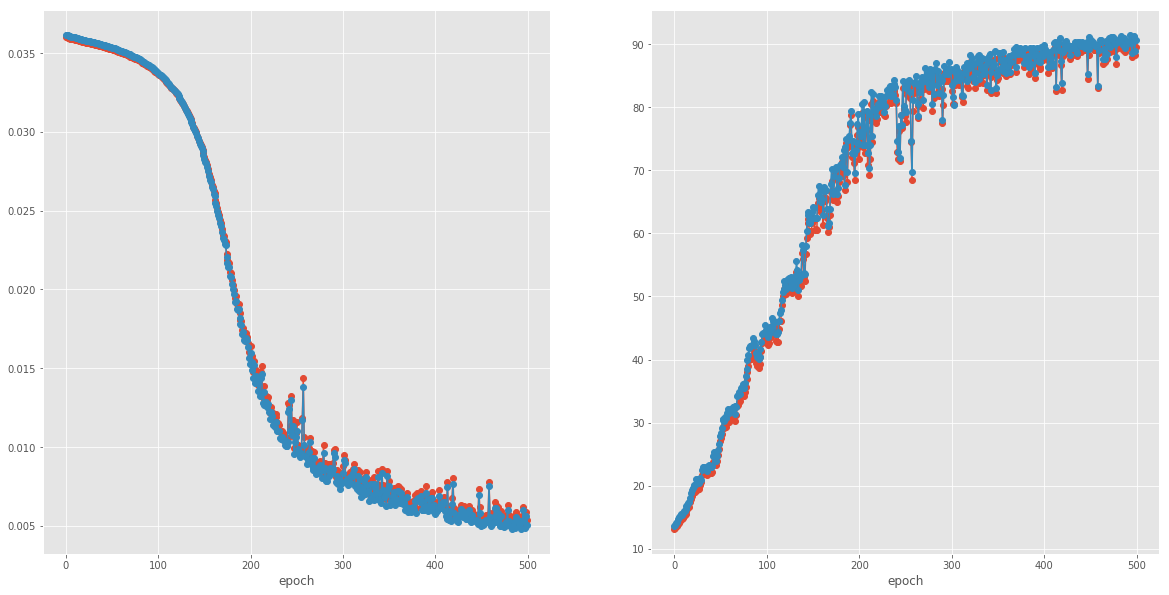

In [15]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,'-o',label='training loss')
plt.plot(valid_loss,'-o',label='test loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(train_acc,'-o',label='training accuracy')
plt.plot(valid_acc,'-o',label='test accuracy')
plt.xlabel('epoch')
plt.savefig(os.path.join(ROOT,'figures', 'mnist_first_try.png'))
plt.show()